In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve
import soundfile as sf
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa
import random
from torch.distributions import Categorical
import wandb
import warnings
warnings.filterwarnings('ignore')

In [19]:
class ASVSpoofDataset(Dataset):
    def __init__(self, root_dir, protocol_file, feature_type='mfcc', max_len=None, is_train=True):
        """
        Args:
            root_dir (string): Directory with all the audio files.
            protocol_file (string): Path to the protocol file.
            feature_type (string): Type of features to extract ('mfcc', 'spec', 'cqt').
            max_len (int): Maximum length of features sequence.
            is_train (bool): Whether this is for training or testing.
        """
        self.root_dir = root_dir
        self.feature_type = feature_type
        self.max_len = max_len
        self.is_train = is_train
        
        # Read protocol file
        self.data = []
        
        print(f"Reading protocol file: {protocol_file}")
        try:
            with open(protocol_file, 'r') as f:
                lines = f.readlines()
                
                # Use tqdm for loading progress
                for line in tqdm(lines, desc=f"Loading {'training' if is_train else 'evaluation'} protocol"):
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        speaker_id = parts[0]
                        file_id = parts[1]
                        label_text = parts[4]
                        label = 1 if label_text == 'bonafide' else 0  # 0 for bonafide, 1 for spoof
                        self.data.append((file_id, label))
            
            # Count number of bonafide and spoof samples
            bonafide_count = sum(1 for _, label in self.data if label == 0)
            spoof_count = sum(1 for _, label in self.data if label == 1)
            
            print(f"Dataset loaded: {len(self.data)} samples ({bonafide_count} bonafide, {spoof_count} spoof)")
            
            if is_train:
                # Subsample for faster NAS
                if len(self.data) > 5000:
                    print(f"Subsampling training data for faster NAS...")
                    np.random.shuffle(self.data)
                    # Keep balanced class distribution
                    bonafide_samples = [item for item in self.data if item[1] == 0][:2500]
                    spoof_samples = [item for item in self.data if item[1] == 1][:2500]
                    self.data = bonafide_samples + spoof_samples
                    np.random.shuffle(self.data)
                    print(f"Subsampled to {len(self.data)} samples")
        
        except Exception as e:
            print(f"Error loading protocol file: {e}")
            self.data = []
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        file_id, label = self.data[idx]
        audio_path = os.path.join(self.root_dir, f"{file_id}.flac")
        
        try:
            audio, sr = sf.read(audio_path)
            
            # Feature extraction
            if self.feature_type == 'mfcc':
                features = extract_mfcc(audio, sr)
            elif self.feature_type == 'spec':
                features = extract_spec(audio, sr)
            elif self.feature_type == 'cqt':
                features = extract_cqt(audio, sr)
            else:
                raise ValueError(f"Unknown feature type: {self.feature_type}")
            
            # Normalize features
            features = (features - np.mean(features)) / (np.std(features) + 1e-8)
            
            # Handle sequence length
            seq_len = features.shape[1]
            if self.max_len is not None:
                if seq_len > self.max_len:
                    start = np.random.randint(0, seq_len - self.max_len) if self.is_train else 0
                    features = features[:, start:start+self.max_len]
                elif seq_len < self.max_len:
                    # Pad with zeros
                    pad_width = ((0, 0), (0, self.max_len - seq_len))
                    features = np.pad(features, pad_width, mode='constant')
            
            return torch.FloatTensor(features), torch.LongTensor([label])[0]
            
        except Exception as e:
            print(f"Error loading {audio_path}: {e}")
            # Return a dummy sample in case of error
            dummy_features = np.zeros((60, 100 if self.max_len is None else self.max_len))
            return torch.FloatTensor(dummy_features), torch.LongTensor([label])[0]

In [20]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Feature extraction functions
def extract_mfcc(audio, sr=16000, n_mfcc=20):
    """Extract MFCC features from audio"""
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    features = np.concatenate([mfcc, delta, delta2], axis=0)
    return features

def extract_spec(audio, sr=16000, n_fft=512, hop_length=256):
    """Extract log mel-spectrogram features from audio"""
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=80)
    log_mel_spec = librosa.power_to_db(mel_spec)
    return log_mel_spec

def extract_cqt(audio, sr=16000, hop_length=256):
    """Extract Constant-Q Transform features from audio"""
    cqt = librosa.cqt(y=audio, sr=sr, hop_length=hop_length)
    return np.abs(cqt)

Using device: cuda


In [21]:
# Neural Architecture Search (NAS) components

# Define the search space
class Operation(nn.Module):
    """Base class for all operations in the search space"""
    def __init__(self, channels, stride=1):
        super(Operation, self).__init__()
        self.channels = channels
        self.stride = stride
    
    def forward(self, x):
        raise NotImplementedError

class ConvBlock(Operation):
    def __init__(self, channels, kernel_size, stride=1):
        super(ConvBlock, self).__init__(channels, stride)
        self.conv = nn.Conv1d(channels, channels, kernel_size, stride=stride, padding=kernel_size//2)
        self.bn = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class LSTM(Operation):
    def __init__(self, channels, stride=1):
        super(LSTM, self).__init__(channels, stride)
        self.lstm = nn.LSTM(channels, channels, batch_first=True)  # Set batch_first=True for simplicity
        self.proj = nn.Linear(channels, channels)  # Simplified projection
        
        # We'll use a Conv1d for adaptation instead of Linear
        # This works better with the expected tensor shapes
        self.input_proj = nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=1)
    
    def forward(self, x):
        # x shape is expected to be [B, C, T] from previous operations
        
        # First, check if we need to adapt the channel dimension
        if x.size(1) != self.channels:
            # Use the 1x1 convolution to adapt the channel dimension
            x = self.input_proj(x)
        
        # Now reshape for LSTM
        batch_size, channels, seq_len = x.size()
        x = x.permute(0, 2, 1)  # [B, C, T] -> [B, T, C]
        
        # LSTM expects [B, T, C] with batch_first=True
        x, _ = self.lstm(x)
        
        # Apply projection if needed
        x = self.proj(x)
        
        # Return to original dimension ordering
        x = x.permute(0, 2, 1)  # [B, T, C] -> [B, C, T]
        
        return x

class Dilated(Operation):
    def __init__(self, channels, stride=1):
        super(Dilated, self).__init__(channels, stride)
        self.conv = nn.Conv1d(channels, channels, 3, stride=stride, padding=2, dilation=2)
        self.bn = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class SkipConnect(Operation):
    def __init__(self, channels, stride=1):
        super(SkipConnect, self).__init__(channels, stride)
    
    def forward(self, x):
        return x

class Attention(Operation):
    def __init__(self, channels, stride=1):
        super(Attention, self).__init__(channels, stride)
        self.query = nn.Conv1d(channels, channels, 1)
        self.key = nn.Conv1d(channels, channels, 1)
        self.value = nn.Conv1d(channels, channels, 1)
        self.scale = torch.sqrt(torch.FloatTensor([channels])).to(device)
    
    def forward(self, x):
        # x shape: [C, T, B]
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        
        # Self-attention
        attention = torch.matmul(q.permute(0, 2, 1), k) / self.scale
        attention = F.softmax(attention, dim=-1)
        x = torch.matmul(attention, v.permute(0, 2, 1)).permute(0, 2, 1)
        return x

# Define the mixed operation (to be controlled by PPO)
class MixedOp(nn.Module):
    def __init__(self, channels, stride=1):
        super(MixedOp, self).__init__()
        self.ops = nn.ModuleList([
            ConvBlock(channels, 3, stride),
            ConvBlock(channels, 5, stride),
            LSTM(channels, stride),
            Dilated(channels, stride),
            SkipConnect(channels, stride),
            Attention(channels, stride)
        ])
    
    def forward(self, x, weights):
        """Forward pass with operation weights"""
        return sum(w * op(x) for w, op in zip(weights, self.ops))

In [22]:
# Cell structure
class Cell(nn.Module):
    def __init__(self, channels, num_nodes=4):
        super(Cell, self).__init__()
        self.channels = channels
        self.num_nodes = num_nodes
        
        # For each node, create edges from all previous nodes
        self.edges = nn.ModuleList()
        for i in range(num_nodes):
            for j in range(i+1):  # connections from input and previous nodes
                self.edges.append(MixedOp(channels))
        
        # Output projection - ensure consistent channel dimension
        self.project = nn.Conv1d(channels * num_nodes, channels, 1)
    
    def forward(self, x, weights):
        """
        Forward pass through the cell
        Args:
            x: Input tensor [B, C, T]
            weights: List of weight tensors for each edge
        """
        # Add debugging print to check dimensions
        #print(f"Cell input shape: {x.shape}")
        
        states = [x]
        offset = 0
        
        # Process each node
        for i in range(self.num_nodes):
            # Gather inputs from previous nodes
            node_inputs = []
            for j in range(i+1):
                edge_output = self.edges[offset + j](states[j], weights[offset + j])
                # Add dimension check
                if edge_output.size(1) != self.channels:
                    print(f"Dimension mismatch at node {i}, edge {j}: expected {self.channels}, got {edge_output.size(1)}")
                    # Add adaptive padding or projection if needed
                    edge_output = F.pad(edge_output, (0, 0, 0, self.channels - edge_output.size(1), 0, 0))
                node_inputs.append(edge_output)
            
            node_input = sum(node_inputs)
            offset += i+1
            states.append(node_input)
        
        # Concatenate all intermediate nodes and check dimensions
        cat_states = torch.cat(states[1:], dim=1)
        #print(f"Concatenated states shape before projection: {cat_states.shape}")
        
        return self.project(cat_states)

In [23]:
# Complete model with cells
class DeepfakeDetectionModel(nn.Module):
    def __init__(self, input_channels, num_cells=3, num_nodes=4, num_ops=6):
        super(DeepfakeDetectionModel, self).__init__()
        self.input_channels = input_channels
        self.num_cells = num_cells
        self.num_nodes = num_nodes
        self.num_ops = num_ops
        
        # Initial projection
        self.stem = nn.Sequential(
            nn.Conv1d(input_channels, 64, 3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        
        # Cells
        self.cells = nn.ModuleList()
        for i in range(num_cells):
            self.cells.append(Cell(64, num_nodes))
        
        # Classification head
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(64, 2)  # Binary classification
        
        # Calculate total number of weights needed
        edges_per_cell = sum(range(1, num_nodes+1))
        self.total_weights = num_cells * edges_per_cell * num_ops
    
    def forward(self, x, architecture_weights):
        """
        Forward pass with specific architecture weights
        Args:
            x: Input features [B, C, T]
            architecture_weights: Architecture weights tensor
        """
        # Check input format and adjust if needed
        if x.shape[1] == self.input_channels:
            # Input is already [B, C, T]
            pass
        else:
            # Input is [B, T, C], convert to [B, C, T]
            x = x.permute(0, 2, 1)
    
        # Process input (no need for permute since we've handled it above)
        x = self.stem(x)
    
        # Reshape weights for each edge
        edge_weights = []
        edges_per_cell = sum(range(1, self.num_nodes+1))
        total_edges = self.num_cells * edges_per_cell
        
        # Split weights by cell and edge
        for i in range(total_edges):
            start_idx = i * self.num_ops
            end_idx = start_idx + self.num_ops
            # Apply softmax to get probability distribution over operations
            edge_weights.append(F.softmax(architecture_weights[start_idx:end_idx], dim=0))
        
        
        
        # Process cells
        offset = 0
        for i, cell in enumerate(self.cells):
            cell_weights = edge_weights[offset:offset + edges_per_cell]
            offset += edges_per_cell
            x = cell(x, cell_weights)
        
        # Classification
        x = self.pool(x).squeeze(-1)
        x = self.classifier(x)
        
        return x

In [24]:
# PPO for architecture search
class PPOController(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(PPOController, self).__init__()
        
        # Actor network (policy)
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, action_dim)
        )
        
        # Critic network (value function)
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, state):
        # Returns action probabilities and estimated value
        action_probs = F.softmax(self.actor(state), dim=-1)
        value = self.critic(state)
        return action_probs, value
    
    def act(self, state):
        action_probs, _ = self.forward(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.detach(), log_prob.detach()
    
    def evaluate(self, state, action):
        action_probs, value = self.forward(state)
        dist = Categorical(action_probs)
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        return log_prob, value, entropy


In [25]:
# PPO Training Function with tqdm progress bar
def train_ppo(controller, optimizer, memories, clip_ratio=0.2, epochs=10, entropy_coef=0.01):
    """Train the PPO controller on collected experiences"""
    # Unpack memories
    states = torch.cat([m['state'] for m in memories])
    actions = torch.cat([m['action'] for m in memories])
    old_log_probs = torch.cat([m['log_prob'] for m in memories])
    rewards = torch.cat([m['reward'] for m in memories])
    
    # Normalize rewards
    rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-8)
    
    # Store metrics for logging
    metrics = {
        'actor_loss': 0,
        'critic_loss': 0,
        'entropy_loss': 0
    }
    
    # Train for multiple epochs with progress bar
    ppo_pbar = tqdm(range(epochs), desc="PPO Training", leave=False)
    
    for _ in ppo_pbar:
        # Evaluate actions
        log_probs, values, entropy = controller.evaluate(states, actions)
        values = values.squeeze(-1)
        
        # Compute ratio and surrogate loss
        ratio = torch.exp(log_probs - old_log_probs)
        surr1 = ratio * rewards
        surr2 = torch.clamp(ratio, 1 - clip_ratio, 1 + clip_ratio) * rewards
        
        # PPO loss
        actor_loss = -torch.min(surr1, surr2).mean()
        critic_loss = F.mse_loss(values, rewards)
        entropy_loss = -entropy.mean()
        
        # Total loss
        loss = actor_loss + 0.5 * critic_loss - entropy_coef * entropy_loss
        
        # Update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update metrics
        metrics['actor_loss'] += actor_loss.item() / epochs
        metrics['critic_loss'] += critic_loss.item() / epochs
        metrics['entropy_loss'] += entropy_loss.item() / epochs
        
        # Update progress bar
        ppo_pbar.set_postfix({
            'actor_loss': f"{actor_loss.item():.4f}",
            'critic_loss': f"{critic_loss.item():.4f}",
            'entropy': f"{entropy.mean().item():.4f}"
        })
    
    return metrics['actor_loss'], metrics['critic_loss'], metrics['entropy_loss']

In [26]:
# Main NAS using PPO
def search_architecture(train_loader, val_loader, device, input_channels=60, num_cells=3, 
                        num_nodes=4, num_ops=6, epochs=50, ppo_updates=5, project_name="deepfake-nas-ppo"):
    """Perform neural architecture search using PPO"""
    # Initialize wandb
    wandb.init(project=project_name, name=f"NAS_cells{num_cells}_nodes{num_nodes}")
    
    # Log hyperparameters
    config = {
        "input_channels": input_channels,
        "num_cells": num_cells,
        "num_nodes": num_nodes,
        "num_ops": num_ops,
        "epochs": epochs,
        "ppo_updates": ppo_updates,
        "model_lr": 0.001,
        "controller_lr": 0.001,
    }
    wandb.config.update(config)
    
    # Initialize model and controller
    model = DeepfakeDetectionModel(input_channels, num_cells, num_nodes, num_ops).to(device)
    
    # State dimension is the validation performance metric
    state_dim = 1
    
    # Action dimension is the total number of weights
    edges_per_cell = sum(range(1, num_nodes+1))
    total_edges = num_cells * edges_per_cell
    action_dim = num_ops  # Number of operations per edge
    
    # Initialize PPO controller
    controller = PPOController(state_dim, action_dim).to(device)
    controller_optimizer = optim.Adam(controller.parameters(), lr=config["controller_lr"])
    
    # Model optimizer
    model_optimizer = optim.Adam(model.parameters(), lr=config["model_lr"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(model_optimizer, 'min', patience=5)
    
    # Metrics tracking
    best_val_eer = 1.0
    best_architecture = None
    
    # Create a progress bar for epochs
    epoch_pbar = tqdm(range(epochs), desc="Architecture Search Progress")
    
    for epoch in epoch_pbar:
        # Train the model with current architecture
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        # For PPO
        memories = []
        current_architecture = []
        
        # Sample architecture for this epoch
        for i in range(total_edges):
            # Use current validation EER as state (normalized between 0 and 1)
            state = torch.FloatTensor([min(best_val_eer, 0.5) * 2]).to(device)  # Scale to [0, 1]
            
            # Sample architecture weights for this edge
            for j in range(num_ops):
                action, log_prob = controller.act(state)
                current_architecture.append(action.item())
                
                # Store experience for PPO
                memories.append({
                    'state': state,
                    'action': action.unsqueeze(0),
                    'log_prob': log_prob.unsqueeze(0),
                    'reward': torch.zeros(1).to(device)  # Will be updated later
                })
        
        # Convert architecture to tensor
        architecture_weights = torch.FloatTensor(current_architecture).to(device)
        
        # Train the model with current architecture
        train_pbar = tqdm(train_loader, desc=f"Training", leave=False)
        for inputs, targets in train_pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            model_optimizer.zero_grad()
            outputs = model(inputs, architecture_weights)
            loss = F.cross_entropy(outputs, targets)
            loss.backward()
            model_optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update training progress bar
            train_pbar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        train_accuracy = 100 * correct / total
        avg_train_loss = train_loss / len(train_loader)
        
        # Validate the model
        model.eval()
        val_loss = 0.0
        all_targets = []
        all_scores = []
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Validation", leave=False)
            for inputs, targets in val_pbar:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs, architecture_weights)
                loss = F.cross_entropy(outputs, targets)
                val_loss += loss.item()
                
                # Get scores for EER calculation
                scores = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Score for spoof class
                all_targets.extend(targets.cpu().numpy())
                all_scores.extend(scores)
                
                # Update validation progress bar
                val_pbar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        # Calculate EER with error handling
        try:
            fpr, tpr, thresholds = roc_curve(all_targets, all_scores, pos_label=1)
            fnr = 1 - tpr
    
            # Check if we have valid values before using nanargmin
            if np.all(np.isnan(fnr - fpr)):
                print("Warning: Cannot calculate EER - all differences are NaN")
                # Provide a fallback value if EER calculation fails
                eer = 0.5  # Default to random guess performance
                eer_threshold = 0.5
            else:
                # Find the index where the difference is minimum
                idx = np.nanargmin(np.absolute(fnr - fpr))
                eer_threshold = thresholds[idx]
                eer = (fpr[idx] + fnr[idx]) / 2
        
        except Exception as e:
            print(f"Error calculating EER: {e}")
            print(f"all_targets shape: {np.shape(all_targets)}, unique values: {np.unique(all_targets)}")
            print(f"all_scores shape: {np.shape(all_scores)}, range: [{np.min(all_scores)}, {np.max(all_scores)}]")
            # Provide fallback values
            eer = 0.5
            eer_threshold = 0.5
        
        avg_val_loss = val_loss / len(val_loader)
        
        # Update epoch progress bar
        epoch_pbar.set_postfix({
            "Train Loss": f"{avg_train_loss:.4f}",
            "Val EER": f"{eer:.4f}",
            "Best EER": f"{best_val_eer:.4f}"
        })
        
        # Log metrics to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "train_accuracy": train_accuracy,
            "val_loss": avg_val_loss,
            "val_eer": eer,
            "best_val_eer": best_val_eer,
            "learning_rate": model_optimizer.param_groups[0]['lr']
        })
        
        # Update PPO rewards based on EER improvement
        reward = best_val_eer - eer if eer < best_val_eer else 0
        for memory in memories:
            memory['reward'] = torch.FloatTensor([reward]).to(device)
        
        # Update best architecture if improved
        if eer < best_val_eer:
            best_val_eer = eer
            best_architecture = architecture_weights.clone()
            
            # Save best model
            checkpoint_path = 'best_deepfake_detection_model.pth'
            torch.save({
                'model_state_dict': model.state_dict(),
                'architecture': best_architecture,
                'eer': best_val_eer,
                'epoch': epoch + 1
            }, checkpoint_path)
            
            # Log best model to wandb
            wandb.save(checkpoint_path)
            
            # Log best architecture visualization
            visualize_architecture(best_architecture, num_cells, num_nodes, num_ops, save_to_wandb=True)
            
            print(f"\nNew best architecture found! EER: {best_val_eer:.4f}")
        
        # Update learning rate
        scheduler.step(eer)
        
        # Update PPO controller if enough data
        if epoch % ppo_updates == 0 and len(memories) > 0:
            actor_loss, critic_loss, entropy_loss = train_ppo(
                controller, controller_optimizer, memories)
            
            # Log PPO metrics
            wandb.log({
                "actor_loss": actor_loss,
                "critic_loss": critic_loss,
                "entropy_loss": entropy_loss
            })
    
    # Finish wandb run
    wandb.finish()
    
    return model, best_architecture, best_val_eer

In [27]:
# Utility functions for evaluation
def evaluate_model(model, architecture, test_loader, device, log_to_wandb=True):
    """Evaluate the model with the best architecture"""
    model.eval()
    all_targets = []
    all_scores = []
    test_loss = 0.0
    correct = 0
    total = 0
    
    # Create a progress bar for evaluation
    eval_pbar = tqdm(test_loader, desc="Evaluating")
    
    with torch.no_grad():
        for inputs, targets in eval_pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, architecture)
            
            # Compute loss
            loss = F.cross_entropy(outputs, targets)
            test_loss += loss.item()
            
            # Compute accuracy
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Get scores for EER calculation
            scores = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Score for spoof class
            all_targets.extend(targets.cpu().numpy())
            all_scores.extend(scores)
            
            # Update progress bar with current metrics
            eval_pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "accuracy": f"{100.0 * correct / total:.2f}%"
            })
    
    # Calculate test accuracy
    test_accuracy = 100.0 * correct / total
    avg_test_loss = test_loss / len(test_loader)
    # Calculate EER
    try:
        fpr, tpr, thresholds = roc_curve(all_targets, all_scores, pos_label=1)
        fnr = 1 - tpr
    
        # Check if we have valid values before using nanargmin
        if np.all(np.isnan(fnr - fpr)):
            print("Warning: Cannot calculate EER - all differences are NaN")
            # Provide a fallback value if EER calculation fails
            eer = 0.5  # Default to random guess performance
            eer_threshold = 0.5
        else:
            # Find the index where the difference is minimum
            idx = np.nanargmin(np.absolute(fnr - fpr))
            eer_threshold = thresholds[idx]
            eer = (fpr[idx] + fnr[idx]) / 2
        
    except Exception as e:
        print(f"Error calculating EER: {e}")
        print(f"all_targets shape: {np.shape(all_targets)}, unique values: {np.unique(all_targets)}")
        print(f"all_scores shape: {np.shape(all_scores)}, range: [{np.min(all_scores)}, {np.max(all_scores)}]")
        # Provide fallback values
        eer = 0.5
        eer_threshold = 0.5
    
    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'ROC Curve (EER = {eer:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Deepfake Detection')
    plt.legend(loc="lower right")
    
    # Save ROC curve
    roc_curve_path = 'roc_curve.png'
    plt.savefig(roc_curve_path)
    
    # Print results
    print(f"\nTest Results - Loss: {avg_test_loss:.4f}, Accuracy: {test_accuracy:.2f}%, EER: {eer:.4f}, EER Threshold: {eer_threshold:.4f}")
    
    # Log to wandb if requested
    if log_to_wandb:
        # Initialize wandb if it's not already running
        if wandb.run is None:
            wandb.init(project="deepfake-nas-ppo", name="final_evaluation")
        
        # Log metrics
        wandb.log({
            "test_loss": avg_test_loss,
            "test_accuracy": test_accuracy,
            "test_eer": eer,
            "eer_threshold": eer_threshold
        })
        
        # Log ROC curve
        wandb.log({"roc_curve": wandb.Image(roc_curve_path)})
        
        # Log confusion matrix
        cm = np.zeros((2, 2))
        for i in range(len(all_targets)):
            pred_class = 1 if all_scores[i] > eer_threshold else 0
            cm[all_targets[i]][pred_class] += 1
        
        # Normalize confusion matrix
        cm_norm = cm / cm.sum(axis=1, keepdims=True)
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        plt.imshow(cm_norm, cmap='Blues')
        plt.colorbar()
        plt.title('Normalized Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks([0, 1], ['Bonafide', 'Spoof'])
        plt.yticks([0, 1], ['Bonafide', 'Spoof'])
        
        # Add text annotations
        for i in range(2):
            for j in range(2):
                plt.text(j, i, f'{cm[i, j]:.0f}\n({cm_norm[i, j]:.2f})', 
                         ha='center', va='center', 
                         color='white' if cm_norm[i, j] > 0.5 else 'black')
        
        cm_path = 'confusion_matrix.png'
        plt.savefig(cm_path)
        wandb.log({"confusion_matrix": wandb.Image(cm_path)})
    
    return eer, eer_threshold

def visualize_architecture(architecture, num_cells, num_nodes, num_ops, save_to_wandb=False):
    """Visualize the architecture weights"""
    edges_per_cell = sum(range(1, num_nodes+1))
    
    plt.figure(figsize=(15, 10))
    
    # Operation names for better visualization
    op_names = ['Conv3x3', 'Conv5x5', 'LSTM', 'Dilated', 'SkipConn', 'Attention']
    
    for cell in range(num_cells):
        plt.subplot(num_cells, 1, cell+1)
        
        edge_idx = 0
        weights_matrix = np.zeros((num_nodes+1, num_nodes))
        
        # Create a matrix to store the operation types
        op_matrix = np.empty((num_nodes+1, num_nodes), dtype=object)
        
        for i in range(num_nodes):
            for j in range(i+1):
                start_idx = (cell * edges_per_cell + edge_idx) * num_ops
                edge_weights = F.softmax(architecture[start_idx:start_idx+num_ops].cpu(), dim=0).numpy()
                strongest_op = np.argmax(edge_weights)
                weights_matrix[j, i] = strongest_op + 1  # +1 for better visualization
                op_matrix[j, i] = op_names[strongest_op] if strongest_op < len(op_names) else f"Op{strongest_op}"
                edge_idx += 1
        
        # Create heatmap with annotations
        plt.imshow(weights_matrix, cmap='viridis')
        plt.colorbar(ticks=range(1, num_ops+2))
        
        # Add text annotations for operation types
        for i in range(num_nodes):
            for j in range(i+1):
                if op_matrix[j, i] is not None:
                    plt.text(i, j, op_matrix[j, i], ha="center", va="center", 
                             color="white" if weights_matrix[j, i] > num_ops/2 else "black",
                             fontsize=8)
        
        plt.title(f'Cell {cell+1} Architecture')
        plt.xlabel('Destination Node')
        plt.ylabel('Source Node')
    
    plt.tight_layout()
    
    # Save figure
    fig_path = 'architecture_visualization.png'
    plt.savefig(fig_path)
    
    # Log to wandb if requested
    if save_to_wandb:
        wandb.log({"architecture_visualization": wandb.Image(fig_path)})
    
    return fig_path

In [28]:
# Main function to run the entire pipeline
def main():
    # Import time for experiment naming
    import time
    import os
    
    # Initialize wandb for the entire experiment
    experiment_name = f"ASVspoof2019_NAS_PPO_{int(time.time())}"
    
    print("Starting Deepfake Audio Detection with NAS and PPO")
    print("=" * 80)
    
    # Paths and parameters (based on the provided dataset structure)
    base_dir = "/kaggle/input/asvspoof-dataset-2019"
    data_dir_train = os.path.join(base_dir, "LA", "ASVspoof2019_LA_train", "flac")
    data_dir_dev = os.path.join(base_dir, "LA", "ASVspoof2019_LA_dev", "flac")
    data_dir_eval = os.path.join(base_dir, "LA", "ASVspoof2019_LA_eval", "flac")
    
    train_protocol = os.path.join(base_dir, "LA", "ASVspoof2019_LA_cm_protocols", "ASVspoof2019.LA.cm.train.trn.txt")
    dev_protocol = os.path.join(base_dir, "LA", "ASVspoof2019_LA_cm_protocols", "ASVspoof2019.LA.cm.dev.trl.txt")
    eval_protocol = os.path.join(base_dir, "LA", "ASVspoof2019_LA_cm_protocols", "ASVspoof2019.LA.cm.eval.trl.txt")
    
    # Log dataset information
    print(f"Train data directory: {data_dir_train}")
    print(f"Train protocol file: {train_protocol}")
    print(f"Dev data directory: {data_dir_dev}")
    print(f"Dev protocol file: {dev_protocol}")
    print(f"Eval data directory: {data_dir_eval}")
    print(f"Eval protocol file: {eval_protocol}")
    
    # Experiment configuration
    feature_type = 'mfcc'  # Options: 'mfcc', 'spec', 'cqt'
    max_seq_len = 400
    batch_size_train = 32
    batch_size_eval = 64
    num_workers = 4

    wandb.login(key="373119fa114178ac5e09f36834a61c071debfbb8")
    # Initialize wandb
    wandb.init(
        project="ASVspoof2019-NAS-PPO",
        name=experiment_name,
        config={
            "feature_type": feature_type,
            "max_sequence_length": max_seq_len,
            "batch_size_train": batch_size_train,
            "batch_size_eval": batch_size_eval,
            "num_workers": num_workers,
            "dataset": "ASVspoof2019 LA"
        }
    )
    
    # Create datasets with tqdm progress for loading
    print("Creating datasets...")
    
    print("Loading training dataset...")
    train_dataset = ASVSpoofDataset(
        root_dir=data_dir_train,
        protocol_file=train_protocol,
        feature_type=feature_type,
        max_len=max_seq_len,
        is_train=True
    )
    
    print("Loading validation dataset...")
    dev_dataset = ASVSpoofDataset(
        root_dir=data_dir_dev,
        protocol_file=dev_protocol,
        feature_type=feature_type,
        max_len=max_seq_len,
        is_train=False
    )
    
    print("Loading evaluation dataset...")
    eval_dataset = ASVSpoofDataset(
        root_dir=data_dir_eval,
        protocol_file=eval_protocol,
        feature_type=feature_type,
        max_len=max_seq_len,
        is_train=False
    )
    
    # Log dataset sizes
    print(f"Training dataset size: {len(train_dataset)} samples")
    print(f"Validation dataset size: {len(dev_dataset)} samples")
    print(f"Evaluation dataset size: {len(eval_dataset)} samples")
    wandb.log({
        "train_dataset_size": len(train_dataset),
        "val_dataset_size": len(dev_dataset),
        "eval_dataset_size": len(eval_dataset)
    })
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size_train, 
        shuffle=True, 
        num_workers=num_workers,
        pin_memory=True
    )
    
    dev_loader = DataLoader(
        dev_dataset, 
        batch_size=batch_size_eval, 
        shuffle=False, 
        num_workers=num_workers,
        pin_memory=True
    )
    
    eval_loader = DataLoader(
        eval_dataset, 
        batch_size=batch_size_eval, 
        shuffle=False, 
        num_workers=num_workers,
        pin_memory=True
    )
    
    # Architecture search parameters
    nas_config = {
        "input_channels": 60,  # 20 MFCCs x 3 (static, delta, delta-delta)
        "num_cells": 3,
        "num_nodes": 4,
        "num_ops": 6,
        "epochs": 30,
        "ppo_updates": 5,
        "project_name": "ASVspoof2019-NAS-PPO"
    }
    
    # Log NAS configuration
    print("\nNeural Architecture Search Configuration:")
    for key, value in nas_config.items():
        print(f"  {key}: {value}")
    
    # Create output directory for results
    output_dir = f"/kaggle/working/results_{experiment_name}"
    os.makedirs(output_dir, exist_ok=True)
    print(f"\nResults will be saved to {output_dir}")
    
    # Perform architecture search with wandb logging
    print("\nStarting Neural Architecture Search...")
    model, best_architecture, best_val_eer = search_architecture(
        train_loader=train_loader,
        val_loader=dev_loader,
        device=device,
        input_channels=nas_config["input_channels"],
        num_cells=nas_config["num_cells"],
        num_nodes=nas_config["num_nodes"],
        num_ops=nas_config["num_ops"],
        epochs=nas_config["epochs"],
        ppo_updates=nas_config["ppo_updates"],
        project_name=nas_config["project_name"]
    )
    
    # Save best architecture
    torch.save(best_architecture, os.path.join(output_dir, "best_architecture.pt"))
    
    # Initialize a new wandb run for final evaluation
    wandb.finish()  # Finish the NAS run
    wandb.init(
        project="ASVspoof2019-NAS-PPO",
        name=f"{experiment_name}_final_evaluation",
        config={
            "feature_type": feature_type,
            "best_val_eer": best_val_eer
        }
    )
    
    # Evaluate on the evaluation set
    print("\nPerforming final evaluation on test set...")
    test_eer, eer_threshold = evaluate_model(model, best_architecture, eval_loader, device)
    
    # Log final metrics
    wandb.log({
        "final_test_eer": test_eer,
        "eer_threshold": eer_threshold
    })
    
    # Visualize the architecture with annotations
    print("\nVisualizing the best architecture...")
    fig_path = visualize_architecture(best_architecture, 
                                     num_cells=nas_config["num_cells"], 
                                     num_nodes=nas_config["num_nodes"], 
                                     num_ops=nas_config["num_ops"],
                                     save_to_wandb=True)
    
    # Save architecture visualization
    import shutil
    shutil.copy(fig_path, os.path.join(output_dir, "architecture_visualization.png"))
    
    # Create a summary report
    summary = {
        "experiment_name": experiment_name,
        "feature_type": feature_type,
        "best_validation_eer": best_val_eer,
        "test_eer": test_eer,
        "eer_threshold": eer_threshold,
        "model_architecture": {
            "num_cells": nas_config["num_cells"],
            "num_nodes": nas_config["num_nodes"],
            "num_operations": nas_config["num_ops"]
        }
    }
    
    # Save summary as JSON
    import json
    with open(os.path.join(output_dir, "summary.json"), "w") as f:
        json.dump(summary, f, indent=4)
    
    # Also save as text for easy reading
    with open(os.path.join(output_dir, "summary.txt"), "w") as f:
        f.write("ASVspoof 2019 Deepfake Detection Summary\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Experiment name: {experiment_name}\n")
        f.write(f"Feature type: {feature_type}\n\n")
        f.write("Performance metrics:\n")
        f.write(f"  Best validation EER: {best_val_eer:.4f}\n")
        f.write(f"  Test EER: {test_eer:.4f}\n")
        f.write(f"  EER threshold: {eer_threshold:.4f}\n\n")
        f.write("Model architecture:\n")
        f.write(f"  Number of cells: {nas_config['num_cells']}\n")
        f.write(f"  Number of nodes per cell: {nas_config['num_nodes']}\n")
        f.write(f"  Number of operations: {nas_config['num_ops']}\n")
    
    # Log summary to wandb
    wandb.save(os.path.join(output_dir, "summary.txt"))
    wandb.save(os.path.join(output_dir, "summary.json"))
    
    print("\nExperiment completed!")
    print(f"Final Test EER: {test_eer:.4f}, EER Threshold: {eer_threshold:.4f}")
    print(f"All results saved to {output_dir}")
    print("=" * 80)
    
    # Finish wandb
    wandb.finish()



wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Starting Deepfake Audio Detection with NAS and PPO
Train data directory: /kaggle/input/asvspoof-dataset-2019/LA/ASVspoof2019_LA_train/flac
Train protocol file: /kaggle/input/asvspoof-dataset-2019/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt
Dev data directory: /kaggle/input/asvspoof-dataset-2019/LA/ASVspoof2019_LA_dev/flac
Dev protocol file: /kaggle/input/asvspoof-dataset-2019/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt
Eval data directory: /kaggle/input/asvspoof-dataset-2019/LA/ASVspoof2019_LA_eval/flac
Eval protocol file: /kaggle/input/asvspoof-dataset-2019/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt
Creating datasets...
Loading training dataset...
Reading protocol file: /kaggle/input/asvspoof-dataset-2019/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt


Loading training protocol: 100%|██████████| 25380/25380 [00:00<00:00, 1357244.94it/s]


Dataset loaded: 25380 samples (2580 bonafide, 22800 spoof)
Subsampling training data for faster NAS...
Subsampled to 5000 samples
Loading validation dataset...
Reading protocol file: /kaggle/input/asvspoof-dataset-2019/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt


Loading evaluation protocol: 100%|██████████| 24844/24844 [00:00<00:00, 1519308.44it/s]


Dataset loaded: 24844 samples (2548 bonafide, 22296 spoof)
Loading evaluation dataset...
Reading protocol file: /kaggle/input/asvspoof-dataset-2019/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt


Loading evaluation protocol: 100%|██████████| 71237/71237 [00:00<00:00, 1461295.52it/s]

Dataset loaded: 71237 samples (7355 bonafide, 63882 spoof)
Training dataset size: 5000 samples
Validation dataset size: 24844 samples
Evaluation dataset size: 71237 samples

Neural Architecture Search Configuration:
  input_channels: 60
  num_cells: 3
  num_nodes: 4
  num_ops: 6
  epochs: 30
  ppo_updates: 5
  project_name: ASVspoof2019-NAS-PPO

Results will be saved to /kaggle/working/results_ASVspoof2019_NAS_PPO_1744672947

Starting Neural Architecture Search...



Training: 100%|██████████| 157/157 [02:02<00:00,  1.65it/s, loss=0.1449]
                                                                        
Architecture Search Progress:   0%|          | 0/30 [08:29<?, ?it/s, Train Loss=0.2028, Val EER=0.0660, Best EER=1.0000]


New best architecture found! EER: 0.0660



Architecture Search Progress:   0%|          | 0/30 [08:30<?, ?it/s, Train Loss=0.2028, Val EER=0.0660, Best EER=1.0000]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x180 and 1x64)

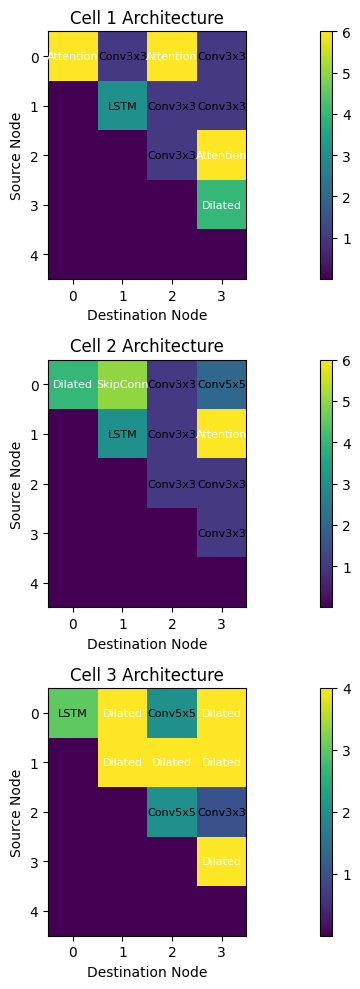

In [29]:
if __name__ == "__main__":
    main()